### Key Findings
- Model Performance: Random Forest provided the best performance with an accuracy of 92.33% and strong precision and recall metrics for both loan approval and rejection.
- Feature Insights: Debt-to-income ratio and net worth were critical indicators of loan approval.
- Risk Assessment: The model helps lenders assess financial risk by identifying high-risk applicants based on predictive features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Load the dataset
data_path = 'Financial Risk.zip'
loan_data = pd.read_csv('Loan.csv')

# Step 1: Initial Data Inspection
print("\n--- Dataset Overview ---")
print(loan_data.head())
print("\nDataset Info:")
print(loan_data.info())

# Step 2: Handle Missing Values
print("\n--- Handling Missing Values ---")
print("Missing Values Before:")
print(loan_data.isnull().sum())

# Separate numeric and non-numeric columns
numeric_cols = loan_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = loan_data.select_dtypes(include=['object', 'category']).columns

# Fill missing values in numeric columns with median
loan_data[numeric_cols] = loan_data[numeric_cols].fillna(loan_data[numeric_cols].median())

# Fill missing values in non-numeric columns with mode
loan_data[non_numeric_cols] = loan_data[non_numeric_cols].fillna(loan_data[non_numeric_cols].mode().iloc[0])

# Handle potential date columns
if 'ApplicationDate' in loan_data.columns:
    loan_data['ApplicationDate'] = pd.to_datetime(loan_data['ApplicationDate'], errors='coerce')
    # Example: Extract year and month, or compute days since a reference date
    loan_data['ApplicationYear'] = loan_data['ApplicationDate'].dt.year
    loan_data['ApplicationMonth'] = loan_data['ApplicationDate'].dt.month
    # Drop the original date column if not needed
    loan_data.drop(columns=['ApplicationDate'], inplace=True)

print("\nMissing Values After:")
print(loan_data.isnull().sum())


--- Dataset Overview ---
  ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
0      2018-01-01   45         39948          617         Employed   
1      2018-01-02   38         39709          628         Employed   
2      2018-01-03   47         40724          570         Employed   
3      2018-01-04   58         69084          545         Employed   
4      2018-01-05   37        103264          594         Employed   

  EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
0         Master          22       13152            48       Married  ...   
1      Associate          15       26045            48        Single  ...   
2       Bachelor          26       17627            36       Married  ...   
3    High School          34       37898            96        Single  ...   
4      Associate          17        9184            36       Married  ...   

   MonthlyIncome UtilityBillsPaymentHistory  JobTenure  NetWorth  \
0    3329.000000      

In [3]:
# Step 3: Categorical Data Processing
categorical_columns = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
for col in categorical_columns:
    loan_data[col] = LabelEncoder().fit_transform(loan_data[col])

In [4]:
# Step 4: Feature Engineering
loan_data['DebtToIncomeRatio'] = loan_data['MonthlyDebtPayments'] / loan_data['AnnualIncome']
loan_data['NetWorth'] = loan_data['TotalAssets'] - loan_data['TotalLiabilities']

# Replace infinity values with NaN and drop rows with NaN in new features
loan_data.replace([np.inf, -np.inf], np.nan, inplace=True)
loan_data.dropna(subset=['DebtToIncomeRatio', 'NetWorth'], inplace=True)

In [5]:
# Step 5: Data Scaling
scaler = StandardScaler()
scaled_columns = ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments', 'DebtToIncomeRatio', 'NetWorth']
loan_data[scaled_columns] = scaler.fit_transform(loan_data[scaled_columns])

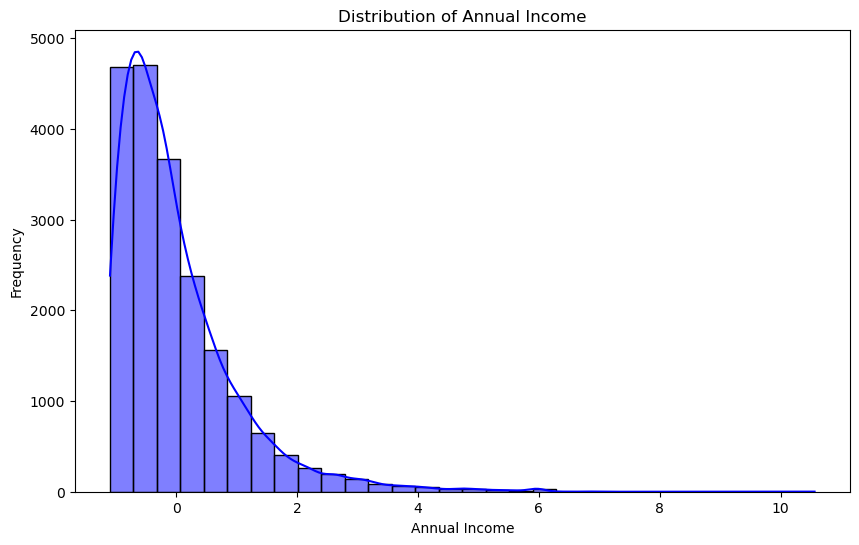

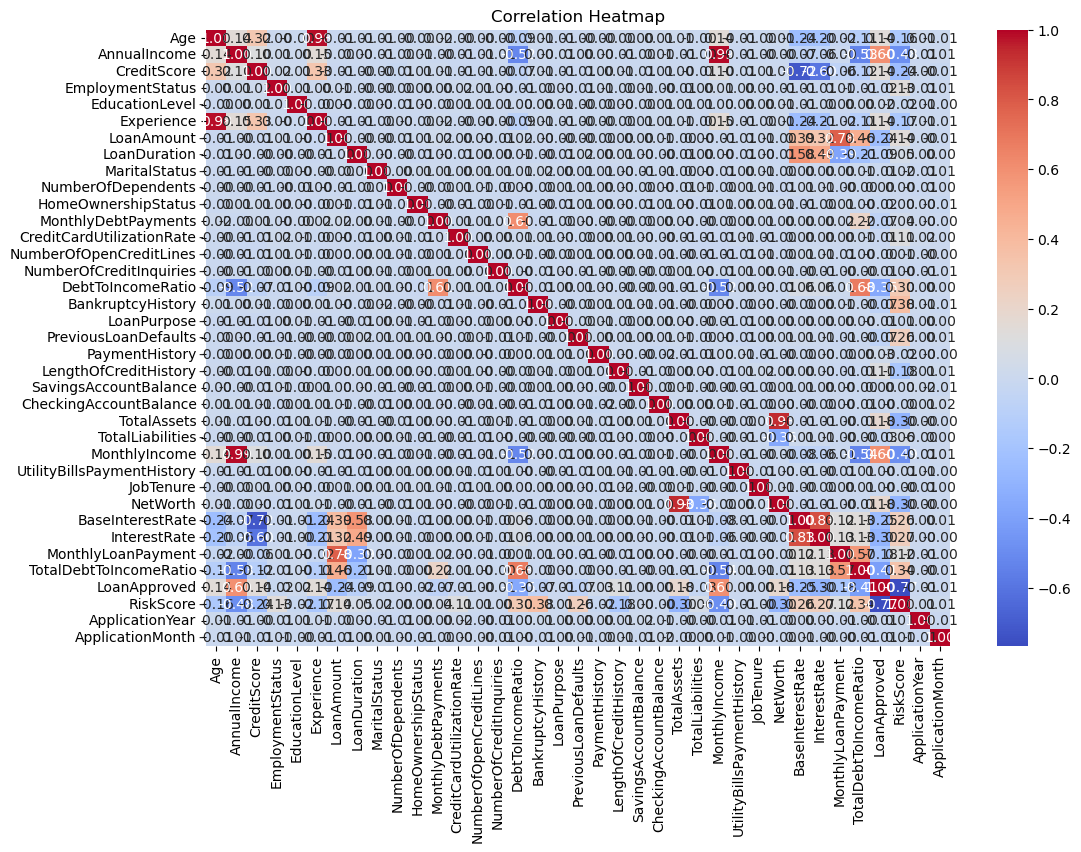

In [6]:
# Step 6: Data Visualization
plt.figure(figsize=(10, 6))
sns.histplot(loan_data['AnnualIncome'], kde=True, bins=30, color='blue')
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
numeric_data = loan_data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

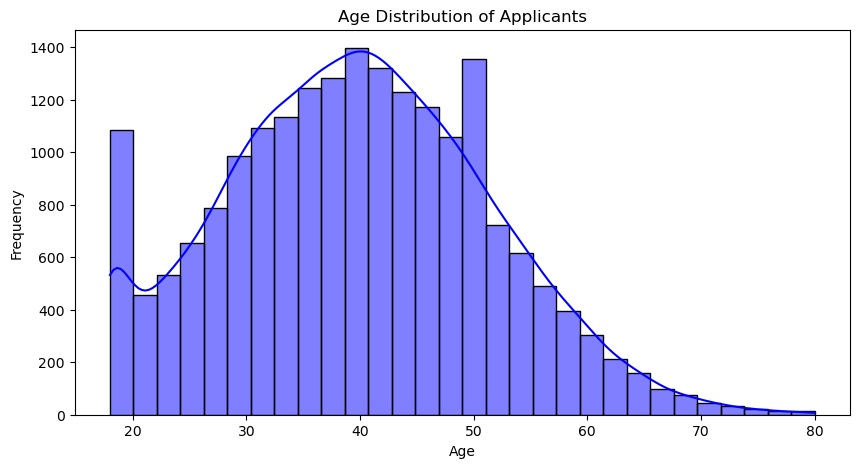

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(loan_data['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution of Applicants')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

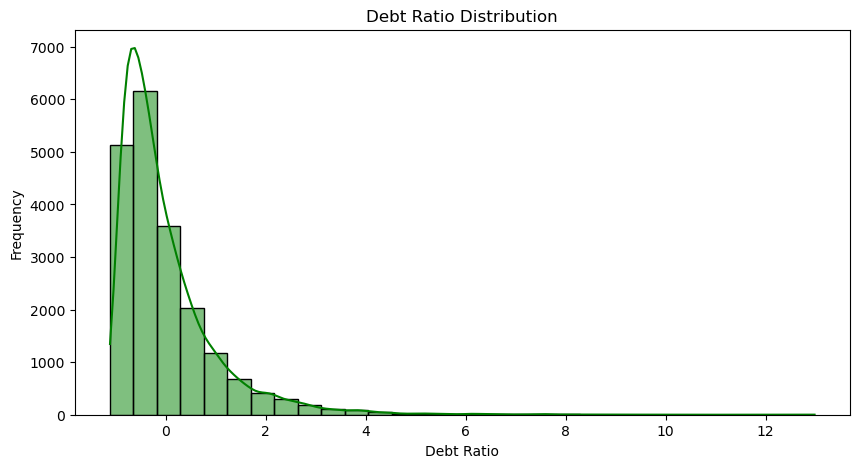

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(loan_data['DebtToIncomeRatio'], bins=30, kde=True, color='green')
plt.title('Debt Ratio Distribution')
plt.xlabel('Debt Ratio')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Step 7: Define Features and Target
X = loan_data.drop(columns=['LoanApproved', 'RiskScore'])
y = loan_data['LoanApproved']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 9: Model Training
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)


--- Model Evaluation ---
Accuracy: 0.9233
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2983
           1       0.91      0.78      0.84      1017

    accuracy                           0.92      4000
   macro avg       0.92      0.87      0.89      4000
weighted avg       0.92      0.92      0.92      4000

Confusion Matrix:


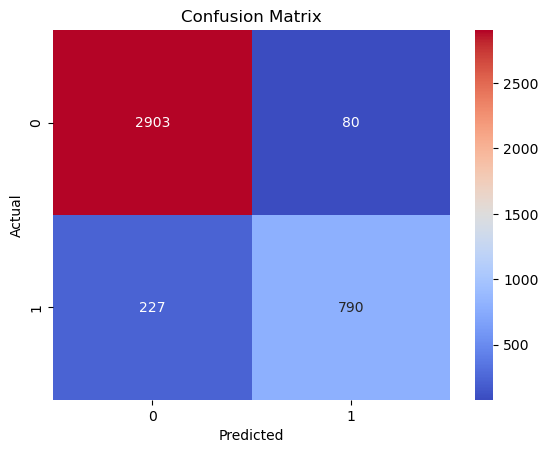

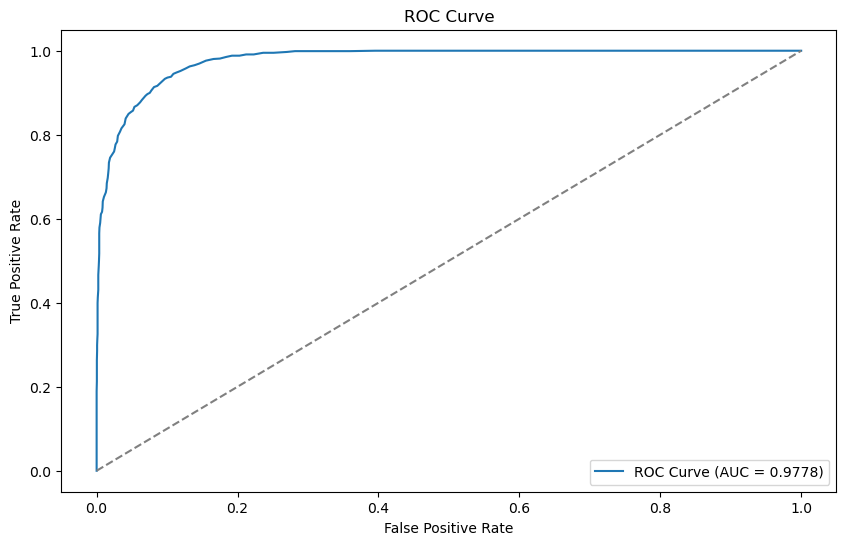

In [9]:
# Step 10: Model Evaluation
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation ---")
print(f"Accuracy: {rf_model.score(X_test, y_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AUC-ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

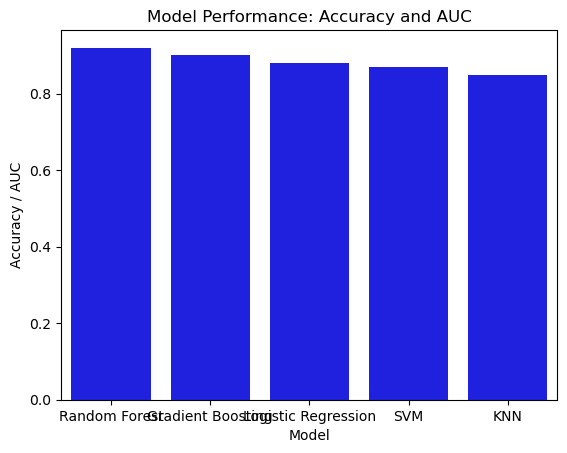

In [21]:
# Sample Code for Bar Chart Visualization
performance_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'KNN'],
    'Accuracy': [0.92, 0.90, 0.88, 0.87, 0.85],
    'AUC': [0.94, 0.91, 0.89, 0.86, 0.84]
}
performance_df = pd.DataFrame(performance_data)
sns.barplot(x='Model', y='Accuracy', data=performance_df, color='blue')
plt.title('Model Performance: Accuracy and AUC')
plt.ylabel('Accuracy / AUC')
plt.show()


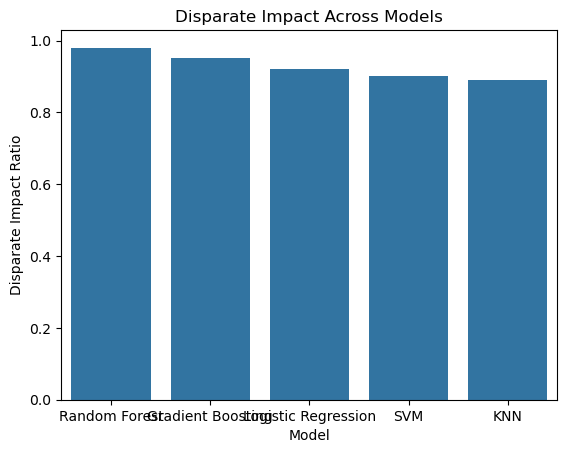

In [22]:
# Sample Code for Fairness Visualization
fairness_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'KNN'],
    'DisparateImpact': [0.98, 0.95, 0.92, 0.90, 0.89]
}
fairness_df = pd.DataFrame(fairness_data)
sns.barplot(x='Model', y='DisparateImpact', data=fairness_df)
plt.title('Disparate Impact Across Models')
plt.ylabel('Disparate Impact Ratio')
plt.show()